In [1]:
# import modules
import uproot, sys, time, random, argparse, copy, csv, json, math, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *


# import trackingError function
from trackingerror import Detector, inputfromfile

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

In [2]:
path = '/data/jlai/iris-hep/OutputPT_shortstrip_only/' # no interaction
# path = '/data/jlai/iris-hep/OutputPT_shortstrip_nointer/'
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

y_acts = {label: [] for label in var_labels}
y_acts_err = {label: [] for label in var_labels}

# pT_values = np.concatenate((np.linspace(1, 15, 15), np.linspace(20, 100, 9)))
pT_values = np.arange(10, 100, 10)
# pT_values = np.arange(20, 100, 10)
# pT_values = np.arange(10, 100, 20)
for pT_value in pT_values:
    pT_value = int(pT_value)
    print(f'Saving ACTS track resol with pT = {pT_value} GeV')
    file = uproot.open(path + f'output_pt_{pT_value}' + '/tracksummary_ckf.root')
    tree = file['tracksummary']

    # < -- Fitting with no plot -- >
    arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit",
                        "t_z0", "eLOC1_fit", "res_eLOC1_fit",
                        "t_phi", "ePHI_fit", "res_ePHI_fit",
                        "t_theta", "eTHETA_fit", "res_eTHETA_fit",
                        "t_p", "t_pT", "eQOP_fit", "res_eQOP_fit",
                        "t_charge"], library='ak')

    pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
    pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['t_theta'])
    # pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

    labels = {
        'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
        'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
        'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
        'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
        'sigma(pt)/pt': ak.flatten( (pT_reco - pT_truth) ) / ak.flatten(pT_reco) 
    }

    plt.figure(figsize=(30, 13))
    for key, data in labels.items():
        data = ak.to_numpy(data)
        data = data[~np.isnan(data)]

        N = len(data)
        mu, sigma = norm.fit(data)

        y_acts[key].append(sigma)
        # y_acts_err[key].append(sigma / np.sqrt(2 * N) if N > 0 else 0)
        y_acts_err[key].append(sigma / np.sqrt(2*max(N-1,1)) if N > 1 else 0.0)

Saving ACTS track resol with pT = 10 GeV
Saving ACTS track resol with pT = 20 GeV
Saving ACTS track resol with pT = 30 GeV
Saving ACTS track resol with pT = 40 GeV
Saving ACTS track resol with pT = 50 GeV
Saving ACTS track resol with pT = 60 GeV
Saving ACTS track resol with pT = 70 GeV
Saving ACTS track resol with pT = 80 GeV
Saving ACTS track resol with pT = 90 GeV


<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

In [18]:

# ========= Your context (must exist in your session) =========
# - pT_values: list/array of pT to evaluate
# - y_acts, y_acts_err: dict[label] -> list of ACTS values/errors
# - inputfromfile: function to load the text geometry file into your calculator
VAR_LABELS = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)']#, 'sigma(pt)/pt']

# ========= Pixel-only base config =========
beam_pipe = (0.00227, 9999.0, 9999.0, 0.024)  # width, resxy, resz, pos (m)
pixel = [(0.014944, 1.328531e-05, 1.328531e-05, 0.032754),
(0.014944, 1.328531e-05, 1.328531e-05, 0.070560),
(0.014944, 1.328531e-05, 1.328531e-05, 0.110162),
(0.014944, 1.328531e-05, 1.328531e-05, 0.165020)]

shortstrip_positions_base = np.array([0.260, 0.360, 0.500, 0.600], dtype=float)
# pixel_base_width = 0.01225
shortstrip_base_width = 0.01475
widths_base = np.array([shortstrip_base_width]*4, dtype=float)  # per-layer widths
resxy_base = 0.043e-3
resz_base  = 1.2e-3
pos_off_base = np.zeros(4, dtype=float)  # per-layer position offsets (m)

# ========= Bounds & steps =========
WIDTH_MIN, WIDTH_MAX = 0, 0.1
# WIDTH_MIN, WIDTH_MAX = max(1e-6, shortstrip_base_width - 0.01225), shortstrip_base_width + 0.040
RESXY_MIN, RESXY_MAX = max(5e-8,  resxy_base - 0.2e-3), resxy_base + 0.2e-3
RESZ_MIN,  RESZ_MAX  = max(5e-8,   resz_base - 1.0e-3),  resz_base + 10.0e-3
POS_MIN,   POS_MAX   = -0.2, 0.2                        # ±5 mm per-layer

# Initial step sizes (fine for res & pos)
w_step_init  = 5e-4         # per-layer width step
rxy_step_init = 5e-7   
rz_step_init  = 2e-6 
p_step_init  = 5e-4         # 0.0005 m per-layer

# Stop when steps fall below:
w_eps, rxy_eps, rz_eps, p_eps = 2e-4, 1e-7, 5e-7, 1e-4

shrink, grow = 0.5, 1.5
max_rounds, patience = 16, 3

# ========= I/O =========
odd_txt_out = "/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/myODD_test.txt"
RUN_DIR = os.path.dirname(odd_txt_out) or "."
LOG_CSV = os.path.join(RUN_DIR, "shortstrip_fit_log.csv")
BEST_JSON = os.path.join(RUN_DIR, "shortstrip_fit_best.json")
BEST_TXT  = os.path.join(RUN_DIR, "myODD_best.txt")

OBJECTIVE = "chi2"  # or "diff"

# ========= Helpers =========
def clamp(x, lo, hi):
    return max(lo, min(hi, x))

def write_shortstrip_only_config(path, widths, resxy, resz, pos_offsets):
    """
    Write beam pipe + 4 pixel layers, per-layer widths & per-layer positions (in meters).
    """
    widths = np.asarray(widths, dtype=float)
    positions = shortstrip_positions_base + np.asarray(pos_offsets, dtype=float)
    widths  = np.maximum(widths, 1e-9)
    resxy   = max(float(resxy), 1e-9)
    resz    = max(float(resz),  1e-9)

    with open(path, "w") as f:
        f.write("# width(x/X0)    resolutionxy(m)    resolutionz(m)    position (m)\n")
        f.write("# beam pipe\n")
        f.write(f"{beam_pipe[0]} {beam_pipe[1]} {beam_pipe[2]} {beam_pipe[3]}\n")
        f.write("# pixel\n")
        for i in range(4):
            f.write(f"{pixel[i][0]} {pixel[i][1]} {pixel[i][2]} {pixel[i][3]}\n")
        f.write("# short strip\n")
        for j in range(4):
            f.write(f"{widths[j]} {resxy} {resz} {positions[j]}\n")

def write_final_txt(path, widths, resxy, resz, pos_offsets):
    """
    Final pretty file in your requested format.
    NOTE: header says (mm) but example values are in meters; we mirror your example.
    """
    widths = np.asarray(widths, dtype=float)
    positions = shortstrip_positions_base + np.asarray(pos_offsets, dtype=float)
    with open(path, "w") as f:
        f.write("#width(x/x0) resolutionxy(mm) resolutionz(mm) position (m)\n")
        f.write("#beam pipe\n")
        f.write("0.00227 9999 9999 0.024\n")
        f.write("#pixel \n")
        for i in range(4):
            f.write(f"{pixel[i][0]} {pixel[i][1]} {pixel[i][2]} {pixel[i][3]}\n")
        f.write("# short strip\n")
        for j in range(4):
            f.write(f"{widths[j]:.6f} {resxy:.6e} {resz:.6e} {positions[j]:.6f}\n")

def cal(inputfile):
    y_calc = {label: [] for label in VAR_LABELS}
    for pT in pT_values:
        p, eta = float(pT), 0.0
        B, m = 2.6, 0.106
        det = inputfromfile(inputfile, 0)
        out = det.errorcalculation(p, B, eta, m)
        for lbl in VAR_LABELS:
            y_calc[lbl].append(out[lbl])
    return y_calc

def metrics(y_calc):
    diff_acc, chi2_acc = 0.0, 0.0
    for lbl in VAR_LABELS:
        acts_vals = np.array(y_acts[lbl], dtype=float)
        acts_errs = np.array(y_acts_err[lbl], dtype=float)
        calc_vals = np.array(y_calc[lbl], dtype=float)
        norm = max(float(np.max(acts_vals)), 1e-12)
        a = acts_vals / norm
        ae = np.maximum(acts_errs / norm, 1e-12)
        c = calc_vals / norm
        diff_acc += float(np.sum(np.abs(c - a)))
        chi2_acc += float(np.sum(((c - a) / ae)**2))
    return diff_acc, chi2_acc

def log_csv_init(path):
    head = ["timestamp","w1","w2","w3","w4","resxy","resz","pos1","pos2","pos3","pos4",
            "diff","chi2","obj","phase","note"]
    if not os.path.exists(path):
        with open(path, "w", newline="") as f:
            csv.writer(f).writerow(head)

def log_csv_row(path, rec, phase, note=""):
    w = rec["widths"]; p = rec["pos"]
    row = [time.strftime("%F_%T"), w[0], w[1], w[2], w[3], rec["resxy"], rec["resz"],
           p[0], p[1], p[2], p[3], rec["diff"], rec["chi2"], rec["obj"], phase, note]
    with open(path, "a", newline="") as f:
        csv.writer(f).writerow(row)

def objective_value(widths, rxy, rz, pos, cache, key_round=9):
    """
    Compute & cache objective; returns dict with diff, chi2, obj, and parameters.
    widths: iterable of 4 per-layer widths (x/X0)
    pos:    iterable of 4 per-layer offsets (m)
    """
    widths = np.asarray(widths, dtype=float)
    pos    = np.asarray(pos, dtype=float)
    key = (tuple(round(float(w), key_round) for w in widths),
           round(float(rxy), key_round),
          round(float(rz),  key_round),
           tuple(round(float(x), key_round) for x in pos))
    if key in cache:
        return cache[key]
    # Clamp
    widths_c = np.clip(widths, WIDTH_MIN, WIDTH_MAX)
    rxy_c    = clamp(float(rxy), RESXY_MIN, RESXY_MAX)
    rz_c     = clamp(float(rz),  RESZ_MIN, RESZ_MAX)
    pos_c    = np.clip(pos, POS_MIN, POS_MAX)
    write_shortstrip_only_config(odd_txt_out, widths_c, rxy_c, rz_c, pos_c)
    try:
        y_calc = cal(odd_txt_out)
        diff_sum, chi2_sum = metrics(y_calc)
        obj = chi2_sum if OBJECTIVE == "chi2" else diff_sum
        if not np.isfinite(obj): obj = float('inf')
    except Exception:
        diff_sum = chi2_sum = float('inf'); obj = float('inf')
    rec = {"widths": list(map(float, widths_c)), "resxy": float(rxy_c), "resz": float(rz_c),
           "pos": list(map(float, pos_c)), "diff": float(diff_sum), "chi2": float(chi2_sum), "obj": float(obj)}
    cache[key] = rec
    return rec

# ========= Search phases =========
def random_warmup(n, cache):
    best = {"obj": float('inf')}
    for _ in tqdm(range(n), desc="Warm-up (random)"):
        # widths = np.random.uniform(WIDTH_MIN, WIDTH_MAX, size=4)
        w = np.random.uniform(WIDTH_MIN, WIDTH_MAX)
        widths = np.full(4, w)

        rxy    = np.random.uniform(RESXY_MIN,   RESXY_MAX)
        rz     = np.random.uniform(RESZ_MIN,   RESZ_MAX)
        pos    = np.random.uniform(POS_MIN,   POS_MAX, size=4)
        rec = objective_value(widths, rxy, rz, pos, cache)
        log_csv_row(LOG_CSV, rec, "warmup", "random")
        if rec["obj"] < best["obj"]: best = rec
    return best

def coarse_grid(cache):
    """
    Tiny coarse sweep: couple of res grid points, and a small set of width/pos patterns.
    Keeps combinatorics tiny.
    """
    rxy_vals = np.linspace(max(RESXY_MIN, resxy_base - 0.001e-3),
                        min(RESXY_MAX, resxy_base + 0.001e-3), 3)
    rz_vals  = np.linspace(max(RESZ_MIN,  resz_base  - 0.010e-3),
                        min(RESZ_MAX,  resz_base  + 0.010e-3), 3)
    delta_w = 5e-4
    delta_p = 5e-4

    dw = 5e-4
    w0 = float(widths_base[0])
    w_list = [w0, w0+dw, w0-dw, w0+2*dw, w0-2*dw]
    width_patterns = [np.full(4, clamp(w, WIDTH_MIN, WIDTH_MAX)) for w in w_list]


    # width_patterns = [
    #     widths_base,                                        # all base
    #     widths_base + delta_w,                              # all +δ
    #     widths_base - delta_w,                              # all -δ
    #     widths_base + np.array([delta_w,0,0,delta_w]),      # outer +δ
    #     widths_base - np.array([delta_w,0,0,delta_w]),      # outer -δ
    #     widths_base + np.array([0,delta_w,delta_w,0]),      # inner +δ
    #     widths_base - np.array([0,delta_w,delta_w,0]),      # inner -δ
    # ]
    pos_patterns = [
        np.zeros(4),
        np.full(4, +delta_p),
        np.full(4, -delta_p),
    ]
    
    dw, dp = delta_w, delta_p
    width_patterns += [
        widths_base + np.array([+dw,+dw,-dw,-dw]),
        widths_base + np.array([-dw,+dw,+dw,-dw]),
    ]
    pos_patterns += [
        np.array([+dp, 0, 0, -dp]),
        np.array([0, +dp, -dp, 0]),
    ]

    best = {"obj": float('inf')}
    total = len(rxy_vals)*len(rz_vals)*len(width_patterns)*len(pos_patterns)
    pbar = tqdm(total=total, desc="Coarse grid (tiny)")
    it = 0
    for rxy in rxy_vals:
        for rz in rz_vals:
            for widths in width_patterns:
                for pos in pos_patterns:
                    rec = objective_value(widths, rxy, rz, pos, cache)
                    log_csv_row(LOG_CSV, rec, "grid", "coarse")
                    if rec["obj"] < best["obj"]:
                        best = rec
                    it += 1; pbar.update(1)
    pbar.close()
    return best

def explore_axis(center, step, lo, hi, plug, cache, label, get_val):
    """
    Explore one scalar axis:
      - center: current scalar value
      - step: step size
      - lo/hi: bounds
      - plug(x): -> (widths, resxy, resz, pos)   (packs the full parameter vector)
      - get_val(rec): extract the scalar coord from 'rec' (e.g. rec['widths'][i], rec['pos'][i], rec['resxy'])
    """
    c = clamp(float(center), lo, hi)
    candidates = [c, clamp(c + step, lo, hi), clamp(c - step, lo, hi)]
    best_local = {"obj": float("inf")}
    for x in candidates:
        rec = objective_value(*plug(x), cache=cache)
        log_csv_row(LOG_CSV, rec, "search", label)
        if rec["obj"] < best_local["obj"]:
            best_local = rec
    # second step in winning direction
    if best_local["obj"] < float("inf"):
        best_coord = float(get_val(best_local))
        if abs(best_coord - c) > 1e-18:
            direction = math.copysign(1.0, best_coord - c)
            x2 = clamp(c + 2.0 * direction * step, lo, hi)
            rec2 = objective_value(*plug(x2), cache=cache)
            log_csv_row(LOG_CSV, rec2, "search", f"{label} 2-step")
            if rec2["obj"] < best_local["obj"]:
                best_local = rec2
    return best_local

def optimize(start, cache):
    widths = np.array(start["widths"], dtype=float)
    rxy, rz = start["resxy"], start["resz"]
    pos = np.array(start["pos"], dtype=float)

    best = objective_value(widths, rxy, rz, pos, cache)
    log_csv_row(LOG_CSV, best, "init", "start")

    w_step, rxy_step, rz_step, p_step = w_step_init, rxy_step_init, rz_step_init, p_step_init
    no_improve = 0

    for rnd in range(1, max_rounds+1):
        improved = False

        # # per-layer widths
        # for i in range(4):
        #     rec_wi = explore_axis(
        #         widths[i], w_step, WIDTH_MIN, WIDTH_MAX,
        #         plug=lambda x, i=i: (np.array([x if j==i else widths[j] for j in range(4)]), rxy, rz, pos),
        #         cache=cache, label=f"width[{i}]",
        #         get_val=lambda rec, i=i: rec["widths"][i],
        #     )
        #     if rec_wi["obj"] + 1e-12 < best["obj"]:
        #         widths[i] = rec_wi["widths"][i]; best, improved = rec_wi, True; w_step *= grow
        #     else:
        #         w_step *= shrink

        # one common width for all 4 layers
        w0 = float(widths[0])
        rec_w = explore_axis(
            w0, w_step, WIDTH_MIN, WIDTH_MAX,
            plug=lambda x: (np.full(4, x), rxy, rz, pos),
            cache=cache, label="width(all)",
            get_val=lambda rec: rec["widths"][0],
        )
        if rec_w["obj"] + 1e-12 < best["obj"]:
            widths[:] = rec_w["widths"][0]
            best, improved = rec_w, True
            w_step *= grow
        else:
            w_step *= shrink


        # resxy
        rec_rxy = explore_axis(
            rxy, rxy_step, RESXY_MIN, RESXY_MAX,
            plug=lambda x: (widths, x, rz, pos),
            cache=cache, label="resxy",
            get_val=lambda rec: rec["resxy"],
        )
        if rec_rxy["obj"] + 1e-12 < best["obj"]:
            rxy, best, improved = rec_rxy["resxy"], rec_rxy, True; rxy_step *= grow
        else:
            rxy_step *= shrink

        # resz
        rec_rz = explore_axis(
            rz, rz_step, RESZ_MIN, RESZ_MAX,
            plug=lambda x: (widths, rxy, x, pos),
            cache=cache, label="resz",
            get_val=lambda rec: rec["resz"],
        )
        if rec_rz["obj"] + 1e-12 < best["obj"]:
            rz, best, improved = rec_rz["resz"], rec_rz, True; rz_step *= grow
        else:
            rz_step *= shrink

        # per-layer positions
        for i in range(4):
            rec_pi = explore_axis(
                pos[i], p_step, POS_MIN, POS_MAX,
                plug=lambda x, i=i: (widths, rxy, rz, np.array([x if j==i else pos[j] for j in range(4)])),
                cache=cache, label=f"pos[{i}]",
                get_val=lambda rec, i=i: rec["pos"][i],
            )
            if rec_pi["obj"] + 1e-12 < best["obj"]:
                pos[i] = rec_pi["pos"][i]; best, improved = rec_pi, True; p_step *= grow
            else:
                p_step *= shrink

        log_csv_row(LOG_CSV, best, "round",
                    f"r={rnd}, steps=(w={w_step:.2g}, rxy={rxy_step:.2g}, rz={rz_step:.2g}, p={p_step:.2g})")

        small = (w_step < w_eps and rxy_step < rxy_eps and rz_step < rz_eps and p_step < p_eps)
        if small: break
        if not improved:
            no_improve += 1
            if no_improve >= patience: break
        else:
            no_improve = 0

    return best

# ========= Driver =========
np.random.seed(42)
os.makedirs(RUN_DIR, exist_ok=True)
log_csv_init(LOG_CSV)
cache = {}

start0 = dict(widths=widths_base, resxy=resxy_base, resz=resz_base, pos=pos_off_base)

# 1) random warm-up
best = random_warmup(n=128, cache=cache)

# 2) tiny coarse grid
best_grid = coarse_grid(cache=cache)
if best_grid["obj"] < best["obj"]:
    best = best_grid

# 3) local adaptive search
best_local = optimize(best, cache)
if best_local["obj"] < best["obj"]:
    best = best_local

# Save results
with open(BEST_JSON, "w") as f:
    json.dump({"best": best, "objective": OBJECTIVE}, f, indent=2)

# Final TXT (per-layer widths + per-layer positions)
write_final_txt(BEST_TXT, best["widths"], best["resxy"], best["resz"], best["pos"])

print("\n=== BEST ({}) ===".format(OBJECTIVE))
print(json.dumps(best, indent=2))
print(f"\nLog CSV:   {LOG_CSV}")
print(f"Best JSON: {BEST_JSON}")
print(f"Best TXT:  {BEST_TXT}")


Warm-up (random):   0%|          | 0/128 [00:00<?, ?it/s]

Coarse grid (tiny): 100%|██████████| 315/315 [00:36<00:00,  8.57it/s]



=== BEST (chi2) ===
{
  "widths": [
    0.007794450456061623,
    0.007794450456061623,
    0.007794450456061623,
    0.007794450456061623
  ],
  "resxy": 4.1700120908149565e-05,
  "resz": 0.008793391357125226,
  "pos": [
    0.07180369017786642,
    0.04462610448954221,
    -0.08188204038691933,
    0.04811615788895178
  ],
  "diff": 0.14564464225363538,
  "chi2": 251.8080135389917,
  "obj": 251.8080135389917
}

Log CSV:   /data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/shortstrip_fit_log.csv
Best JSON: /data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/shortstrip_fit_best.json
Best TXT:  /data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/myODD_best.txt


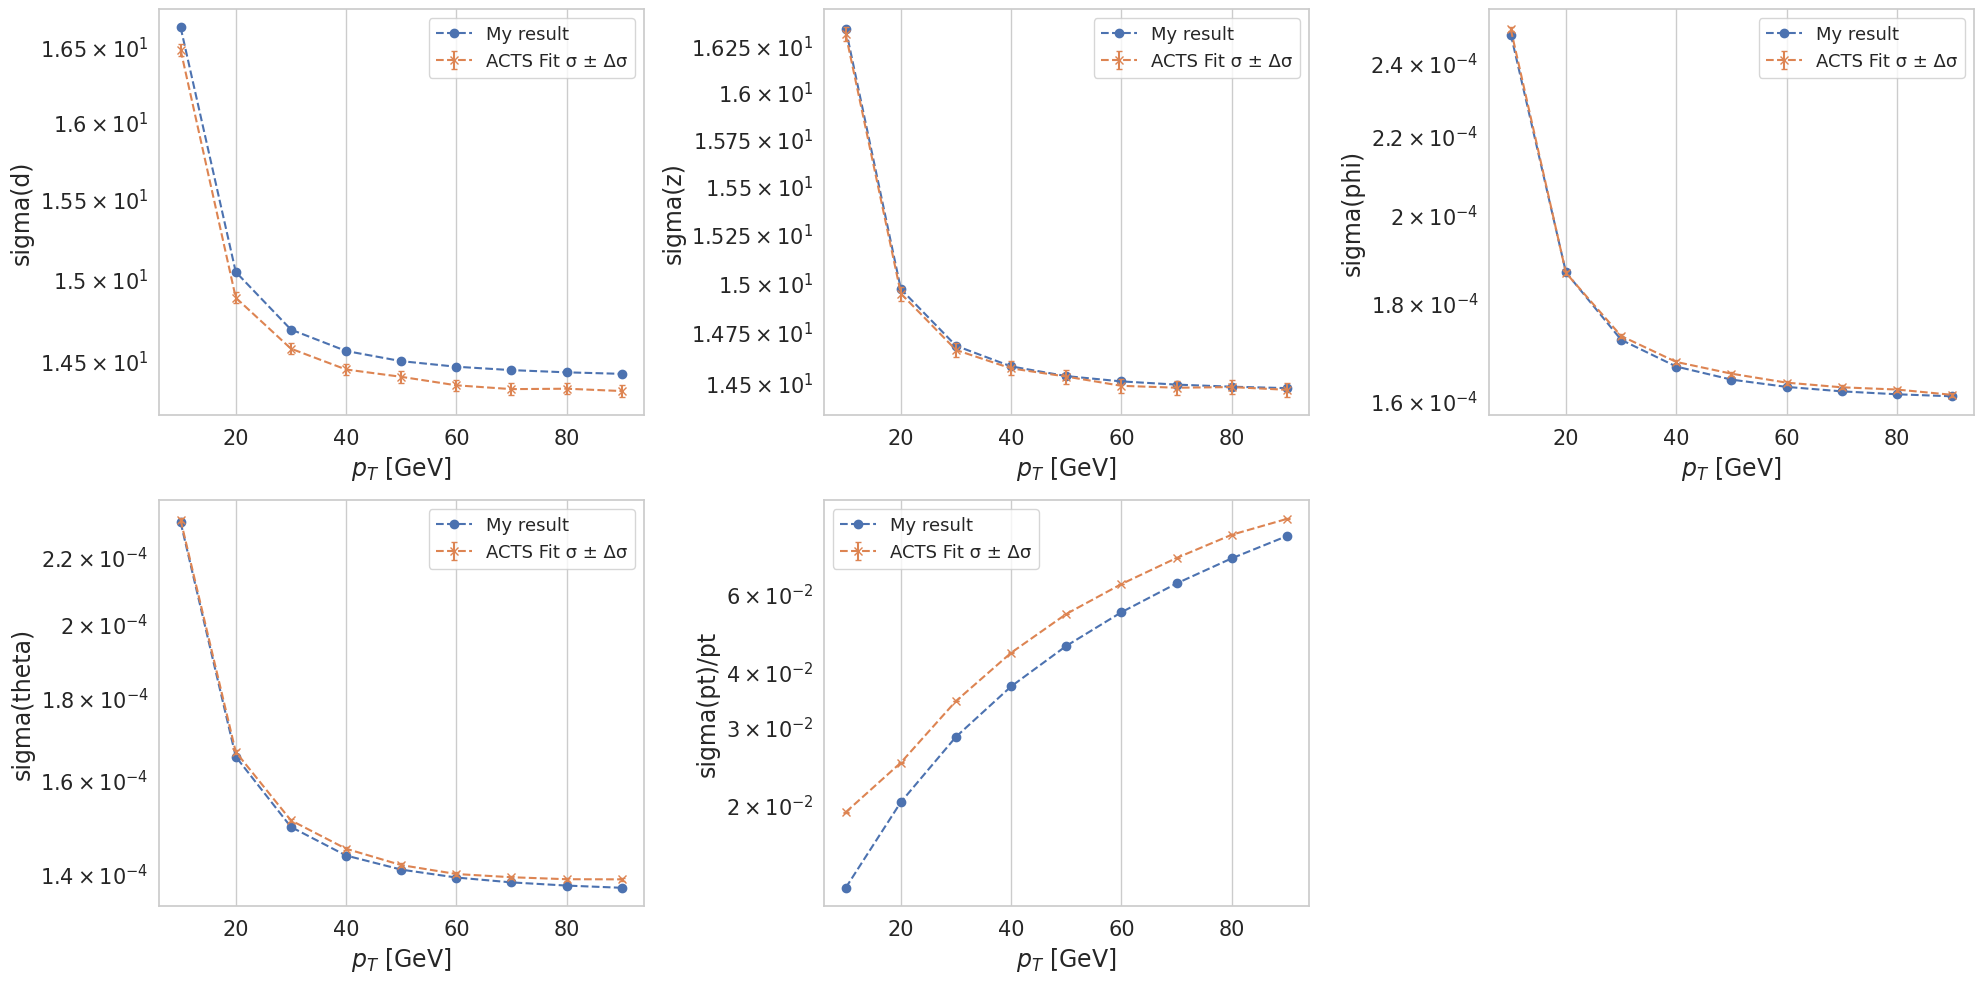

In [ ]:
# < -- Tracking Error Calculator -- >
def cal(inputfile='ODD.txt'):
    y_calc = {label: [] for label in var_labels}

    for pT_value in pT_values:
        pT_value = int(pT_value)
        p, eta = pT_value, 0
        B, m = 2, 0.106
        mydetector = inputfromfile(inputfile, 0)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
y_calc = cal(path+'ODD.txt')
y_calc2 = cal(path+'myODD2.txt')
# y_calc3 = cal(path+'myODD_pixel_only_best.txt')
y_calc3 = cal(path+'myODD_best.txt')
y_calc3 = cal(path+'myODD_test1.txt')

# < -- plot the var vs. pT -- >
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)
    # plt.plot(pT_values, y_calc[var_label], 'o--', label=f"Default Calculator in zenodo")
    # plt.plot(pT_values, y_calc2[var_label], 'o--', label=f"Old width Calculator2")
    plt.plot(pT_values, np.array(y_calc3[var_label]), 'o--', label=f"My result")
    # plt.plot(pT_values, y_acts[var_label], 'x--', label=f"ACTS (fit σ)")
    plt.errorbar(pT_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt='x--', capsize=2, label="ACTS Fit σ ± Δσ")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    # plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
